## GAN
- Generative Adversarial Network
- 적대적으로 경쟁해서 생성하는 네트워크 (적대적 생성망)
### generative model
 - 각 데이터의 확률분포를 추정하고 분포를 기반으로한 새로운 데이터 분류/생성
  > - autoencoder 고차원 데이터를 저차원으로 축소한것이 고유의 특성을 찾았어서 생성에 활용

### Generative Adversarial Network
- 실제처럼 만들고 구분할 수 있도록 서로 **적대적 경쟁(Adversarial)시키면서 발전**

### 학습 테크닉 정리
GAN 학습이 힘듦

- overfitting 막는 방법
  - 데이터 확보

  - 데이터 전처리
    - normalization : 0 ~ 1, -1 ~ 1
  - 모델 단순화
    - feature 수 줄이기:
      - feature selection
        1. filter
        2. wrapper
        3. embeded
      - dimensionality reduction
    - regularizer (weight decay)
  - ensemble
    - dropout
  - early stopping

- **underfitting** 막는 방법
  - Normalization
    - BN
    - layer
    - instance
    - weight
  - ReLU, Leacky ReLU
  - initializer
  - gradient clipping
  - optimizer
  - learning rate decay


### DCGAN
- Deep Convolutional GAN
- simple - deep -convolution

- gradientTape
    - 모델 나누어서
-  Leacky ReLU
    intro to DL (MIT vs Stanford)
    
TensorFlow DCGAN 참고: https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko

In [1]:
import tensorflow as tf

In [2]:
(X_train, y_train),(_,_) =tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
X_train = X_train.reshape(-1,28,28,1)

데이터 전처리
- 정규화 : 0 ~ 1, -1 ~ 1 ( zero-centered)
    - [-1,1] 정규화

In [4]:
X_train = (X_train - 255/2)/(255/2)

In [5]:
BATCH_SIZE = 256
train = tf.data.Dataset.from_tensor_slices(X_train).batch(BATCH_SIZE)

모델을 generator , discriminator나누어서 모델 만듦
### Generator
- BatchNormalization
- LeakyReLU
- Conv2DTranspose
- use_bias=False
- 갯수 맞추기위해서 padding='same'

### LeakyReLU
  f(x) = alpha * x if x < 0  
  f(x) = x if x >= 0  
  https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU

In [11]:
import numpy as np
leaky_relu_layer = tf.keras.layers.LeakyReLU(negative_slope=0.5)
input = np.array([-10, -5, 0.0, 5, 10])
result = leaky_relu_layer(input)
print(list(result.numpy()))

[-5.0, -2.5, 0.0, 5.0, 10.0]


In [12]:
# 구버전 소스라서 오류남
# layer = tf.keras.layers.LeakyReLU()  # 기본값 alpah = 0.3
# output = layer([-3.0, -1.0, 0.0, 2.0])
# print(list(output.numpy()))

# layer = taf.keras.layers.LeakyReLU(alpha=0.1)
# output = layer([-3.0, -1.0, 0.0, 2.0])
# print(list(output.numpy()))

In [13]:
NOISE_DIM=100

def make_generative_model(): #함수로 재활용
    generative_model= tf.keras.models.Sequential([ #첫번째 convolution갯수 맞춰야함

        tf.keras.layers.Dense(7*7*256,input_shape=(NOISE_DIM,),use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Reshape((7, 7, 256)),#convolution형태

        tf.keras.layers.Conv2DTranspose(128,(5,5),padding='same',use_bias=False) ,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(128,(5,5),padding='same', strides=2,use_bias=False) ,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        #마지막 레이어 1
        tf.keras.layers.Conv2DTranspose(1,(5,5),padding='same',strides=2,use_bias=False) , # vgg (3,3),(5,5)
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
      ])
    return generative_model  #28x28x1로 맞춤

In [14]:
generator = make_generative_model()
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 128)         │         409,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,537,604 (9.68 MB)

 Trainable params: 2,512,002 (9.58 MB)

 Non-trainable params: 25,602 (100.01 KB)

- 아직 훈련되지 않은 generator가 이미지 생성

In [15]:
img = generator(tf.random.normal([1,100]))
img.numpy().reshape(1,28,28)

array([[[-1.48918334e-04, -5.34189341e-04,  4.13157791e-03,
          2.27133185e-03, -5.38536930e-04, -2.01853435e-03,
          6.86334819e-03,  1.68961531e-04, -2.38098949e-03,
          5.40006091e-04,  4.83009173e-03, -2.49176775e-03,
         -2.74202204e-04,  4.79703257e-03, -1.16090605e-03,
          6.39257953e-04,  1.92087353e-03, -2.42865924e-03,
          4.59660543e-04, -1.75535667e-03,  4.23346320e-03,
         -9.11947282e-04,  6.94282399e-03,  4.51485300e-03,
          2.44789012e-03,  4.47133789e-04,  1.22232494e-04,
          5.23967156e-03],
        [ 4.63637803e-03,  2.27210578e-03, -6.54952368e-04,
          4.94826585e-03,  4.47135884e-04, -5.48676401e-03,
         -4.81213862e-03,  2.17025029e-03,  2.46256706e-03,
         -1.52529555e-03, -2.28210725e-03, -3.57604562e-03,
         -6.31125702e-04, -2.63901427e-03,  5.61904442e-03,
         -2.67545489e-04,  2.97017465e-03, -7.19848671e-04,
         -4.05376730e-03,  1.52941642e-03, -9.71800357e-04,
          3.8

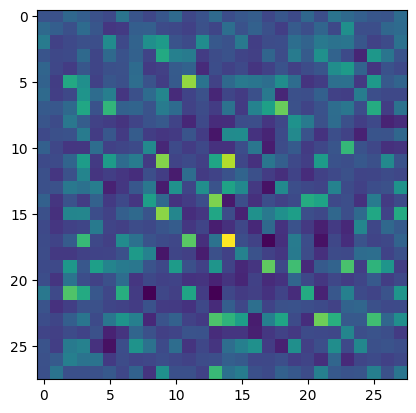

In [16]:
import matplotlib.pyplot as plt
plt.imshow(img.numpy().reshape(28,28))

### Discriminator
- 번갈아가면서 학습시켜서 진짜인지 구분 가능하는 능력을 키움
- CNN기반 분류기

In [17]:
discriminator= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(64,(5,5),input_shape=(28,28,1)),
       tf.keras.layers.LeakyReLU(),
       tf.keras.layers.Dropout(0.3),

       tf.keras.layers.Conv2D(128,(5,5)),
       tf.keras.layers.LeakyReLU(),
       tf.keras.layers.Dropout(0.3),

       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(1) #prediction
       ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 24, 24, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 20, 20, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          51,201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257,793 (1007.00 KB)

 Trainable params: 257,793 (1007.00 KB)

 Non-trainable params: 0 (0.00 B)

훈련되지않은 discriminator 사용하여 판별
- 음수 :가짜
- 양수 :진짜

In [19]:
discriminator(img)   #아직 학습 안해서 생성자의 이미지를 판단 능력 없음

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00080858]], dtype=float32)>

In [20]:
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True) # functional paradigm
#문자열,함수,객체-재활용

In [21]:
#loss 2개 만들어서 사용
def discriminator_loss(real,fake):
    real_loss= loss(tf.ones_like(real),real)
    fake_loss= loss(tf.zeros_like(fake),fake)

    total_loss=real_loss+fake_loss
    return total_loss

In [22]:
def generative_loss(fake):
    return loss(tf.zeros_like(fake),fake)

### optimizer
- 감별자와 생성자는 따로 훈련되서 2개

In [23]:
optimizer_g=tf.keras.optimizers.Adam( )
optimizer_d=tf.keras.optimizers.Adam()

- GradientTape: for 이용해서 epoch별 batch size만큼

In [24]:
NOISE_DIM=100
noise =tf.random.normal([BATCH_SIZE,NOISE_DIM])
real=X_train

In [25]:
# 동시에 두 모델 실행
@tf.function
def train_step(real):
  with tf.GradientTape() as G, tf.GradientTape() as D: #알아서 순차적 실행
    #training학습여부 조절
    imgs=generator(noise,training=True)  #뱃치사이즈 만큼 이미지 만듦

    real_img=discriminator(real, training=True)
    fake_img=discriminator(imgs, training=True) #제너레이터가만든 이미지

    gen_loss=generative_loss(fake_img)
    dis_loss=discriminator_loss(real_img, fake_img)

  gd=G.gradient(gen_loss,generator.trainable_variables)
  dd=D.gradient(dis_loss,discriminator.trainable_variables)
# print(gd)
  optimizer_g.apply_gradients(zip(gd,generator.trainable_variables) )
  optimizer_d.apply_gradients(zip(dd,discriminator.trainable_variables) )

In [26]:
#  Colab에서 1분 소요
for e in range(20): # 10 epochs
  for i in train:
    train_step(i)

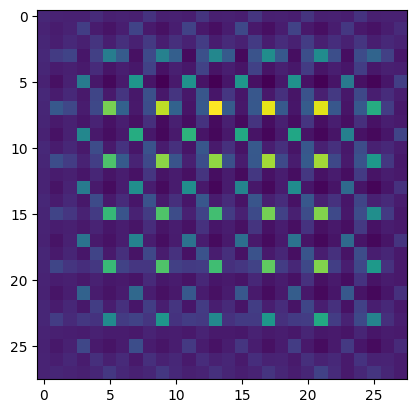

In [27]:
img=generator(tf.random.normal([1,100]))
plt.imshow(img.numpy().reshape(28,28))

In [28]:
discriminator(img)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-56.16581]], dtype=float32)>